# Notebook to retrieve gridded climate time-series data sets

### Case study: the Sauk-Suiattle river watershed, the Elwha river watershed, the Upper Rio Salado watershed
<img src="http://www.sauk-suiattle.com/images/Elliott.jpg" 
style="float:right;width:150px;padding:20px">

### Use this Jupyter Notebook to:
    1. HydroShare setup and preparation
    2. Read in the json file containing the spatial-temporal computations
    3. Visualize the spatial patterns
    4. Visualize the paired temporal patterns

<br/><br/><br/>
<img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png"
style="float:right;width:150px;padding:20px">

<br/><br/>
#### This data is compiled to digitally observe the watersheds, powered by HydroShare. <br/>Provided by the Watershed Dynamics Group, Dept. of Civil and Environmental Engineering, University of Washington

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of 1) Python standard libraries, 2) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and 3) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [ ]:
#conda install -c conda-forge basemap-data-hires --yes

In [1]:
# data processing
import os
import pandas as pd, numpy as np, dask, json
import ogh
import geopandas as gpd

# data migration library
from utilities import hydroshare

# plotting and shape libraries
%matplotlib inline

# silencing warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())

['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [3]:
sorted(meta_file['dailymet_livneh2013'].keys())

['decision_steps',
 'delimiter',
 'domain',
 'end_date',
 'file_format',
 'filename_structure',
 'reference',
 'spatial_resolution',
 'start_date',
 'subdomain',
 'temporal_resolution',
 'variable_info',
 'variable_list',
 'web_protocol']

Establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare. 

In [4]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = jphuong
   HS_RES_ID = 70b977e22af544f8a7e5a803935c329c
   HS_RES_TYPE = genericresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => jphuong
Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/70b977e22af544f8a7e5a803935c329c/70b977e22af544f8a7e5a803935c329c/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

This example uses a shapefile with the watershed boundary of the Sauk-Suiattle Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/c532e0578e974201a0bc40a37ef2d284/. 

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [5]:
"""
Sauk
"""
# Watershed extent
hs.getResourceFromHydroShare('c532e0578e974201a0bc40a37ef2d284')
sauk = hs.content['wbdhub12_17110006_WGS84_Basin.shp']

# reproject the shapefile into WGS84
ogh.reprojShapefile(sourcepath=sauk)

This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? y
Download Finished                               
Successfully downloaded resource c532e0578e974201a0bc40a37ef2d284


### Summarize the file availability from each watershed mapping file

In [6]:
# map the mappingfiles from usecase1
mappingfile1 = os.path.join(homedir,'Sauk_mappingfile.csv')
mappingfile2 = os.path.join(homedir,'Elwha_mappingfile.csv')
mappingfile3 = os.path.join(homedir,'RioSalado_mappingfile.csv')

t1 = ogh.mappingfileSummary(listofmappingfiles = [mappingfile1, mappingfile2, mappingfile3], 
                            listofwatershednames = ['Sauk-Suiattle river','Elwha river','Upper Rio Salado'],
                            meta_file=meta_file)

t1

Watershed                                                Sauk-Suiattle river  \
Median elevation in meters [range](No. gridded cells)  1171[164-2216] (n=99)   
dailymet_bclivneh2013                                  1171[164-2216] (n=99)   
dailymet_livneh2013                                    1171[164-2216] (n=99)   
dailymet_livneh2015                                    1171[164-2216] (n=99)   
dailyvic_livneh2013                                    1171[164-2216] (n=99)   
dailyvic_livneh2015                                    1171[164-2216] (n=99)   
dailywrf_bcsalathe2014                                 1171[164-2216] (n=99)   
dailywrf_salathe2014                                   1171[164-2216] (n=99)   

Watershed                                                        Elwha river  \
Median elevation in meters [range](No. gridded cells)   1120[36-1642] (n=55)   
dailymet_bclivneh2013                                   1120[36-1642] (n=55)   
dailymet_livneh2013                                    1146[174-1642] (n=52)   
dailymet_livneh2015                                     1120[36-1642] (n=55)   
dailyvic_livneh2013                                    1146[174-1642] (n=52)   
dailyvic_livneh2015                                     1120[36-1642] (n=55)   
dailywrf_bcsalathe2014                                  1142[97-1642] (n=53)   
dailywrf_salathe2014                                    1142[97-1642] (n=53)   

Watershed                                                    Upper Rio Salado  
Median elevation in meters [range](No. gridded cells)  2308[1962-2669] (n=31)  
dailymet_bclivneh2013                                                       0  
dailymet_livneh2013                                    2308[1962-2669] (n=31)  
dailymet_livneh2015                                    2308[1962-2669] (n=31)  
dailyvic_livneh2013                                    2308[1962-2669] (n=31)  
dailyvic_livneh2015                                    2308[1962-2669] (n=31)  
dailywrf_bcsalathe2014                                                      0  
dailywrf_salathe2014                                                        0

## 3.  Read in prior spatial-temporal computations

This section performs computations and generates plots of the Livneh 2013, Livneh 2016, and WRF 2014 temperature and precipitation data in order to compare them with each other and observations. The generated plots are automatically downloaded and saved as .png files in the "plots" folder of the user's home directory and inline in the notebook.

In [7]:
# readDictOfDF
ltm = ogh.readDictOfDf()

TypeError: readDictOfDf() missing 1 required positional argument: 'infilepath'

### INPUT: gridded meteorology from Jupyter Hub folders
Data frames for each set of data are stored in a dictionary. The inputs to gridclim_dict() include the folder location and name of the hydrometeorology data, the file start and end, the analysis start and end, and the elevation band to be included in the analsyis (max and min elevation). <br/>  

#### Create a dictionary of climate variables for the long-term mean (ltm).  The dictionary here is initialized with the Livneh et al., 2013 dataset with a dictionary output 'ltm', which is used as an input to the second time we run gridclim_dict(), to add the Salathe et al., 2014 data to the same dictionary. 

In [22]:
sorted(ltm.keys())

['PRECIP_dailymet_livneh2013',
 'TMAX_dailymet_livneh2013',
 'TMIN_dailymet_livneh2013',
 'WINDSPD_dailymet_livneh2013',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_WINDSPD_dailymet_livneh2013',
 'meanallmonthsum_PRECIP_dailymet_livneh2013',
 'meanallyear_PRECIP_dailymet_livneh2013',
 'meanallyear_TMAX_dailymet_livneh2013',
 'meanallyear_TMIN_dailymet_livneh2013',
 'meanallyear_WINDSPD_dailymet_livneh2013',
 'meanallyearsum_PRECIP_dailymet_livneh2013',
 'meanbymonthsum_PRECIP_dailymet_livneh2013',
 'meanbyyearsum_PRECIP_dailymet_livneh2013',
 'meandaily_PRECIP_dailymet_livneh2013',
 'meandaily_TMAX_dailymet_livneh2013',
 'meandaily_TMIN_dailymet_livneh2013',
 'meandaily_WINDSPD_dailymet_livneh2013',
 'meandailysum_PRECIP_dailymet_livneh2013',
 'meanmonth_PRECIP_dailymet_livneh2013',
 'meanmonth_TMAX_dailymet_livneh2013',
 'meanmonth_TMIN_dailymet_livneh2013',
 'meanmonth_WINDSPD_dailymet_livneh2013',

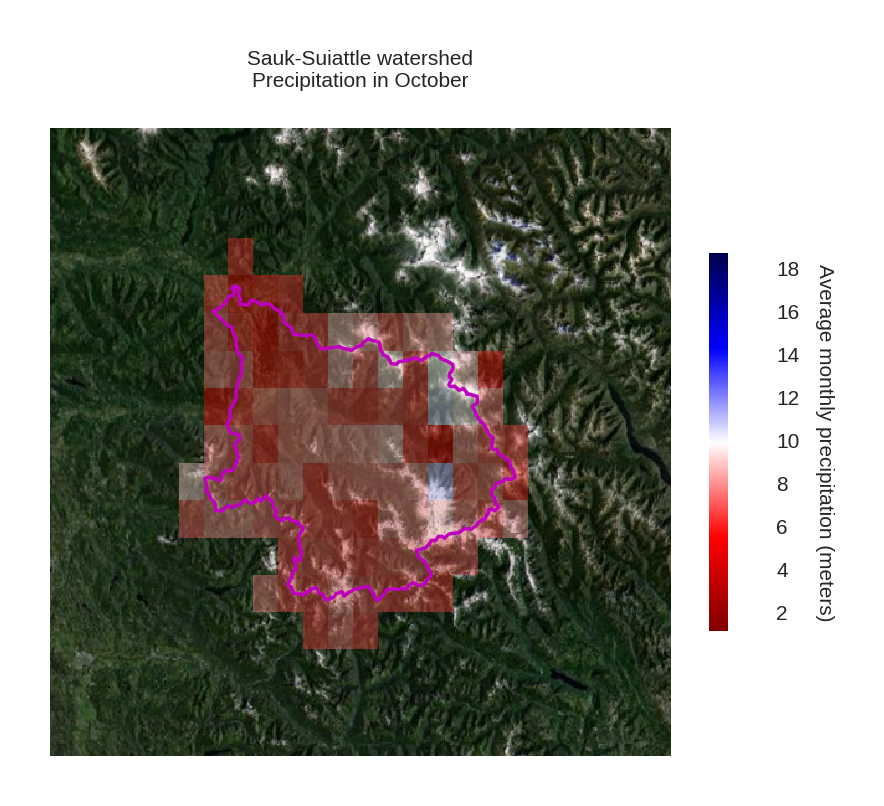

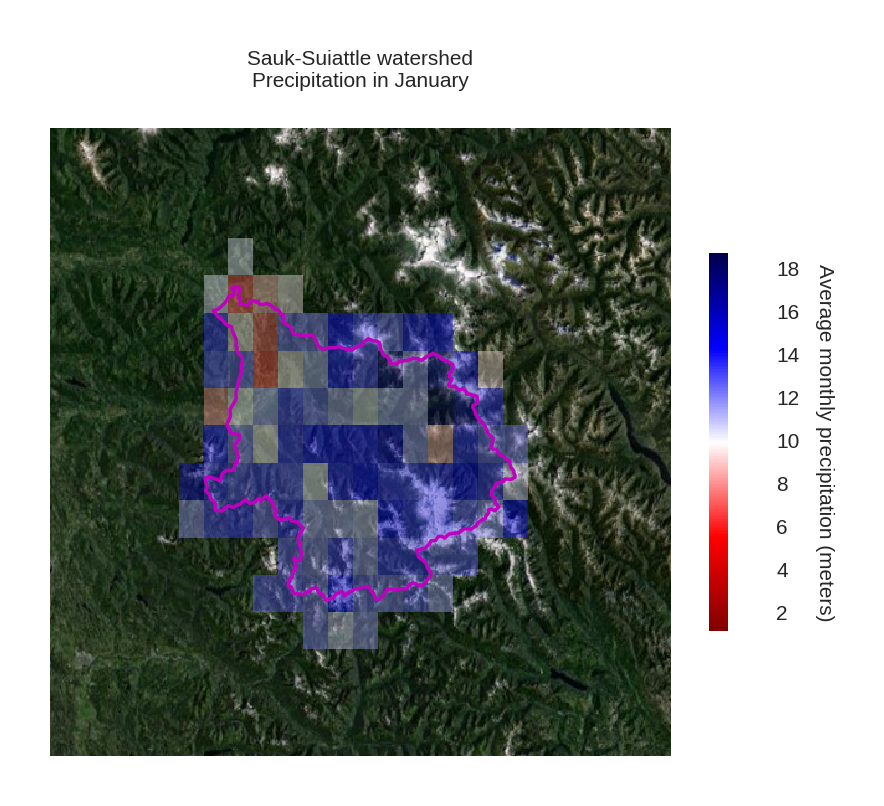

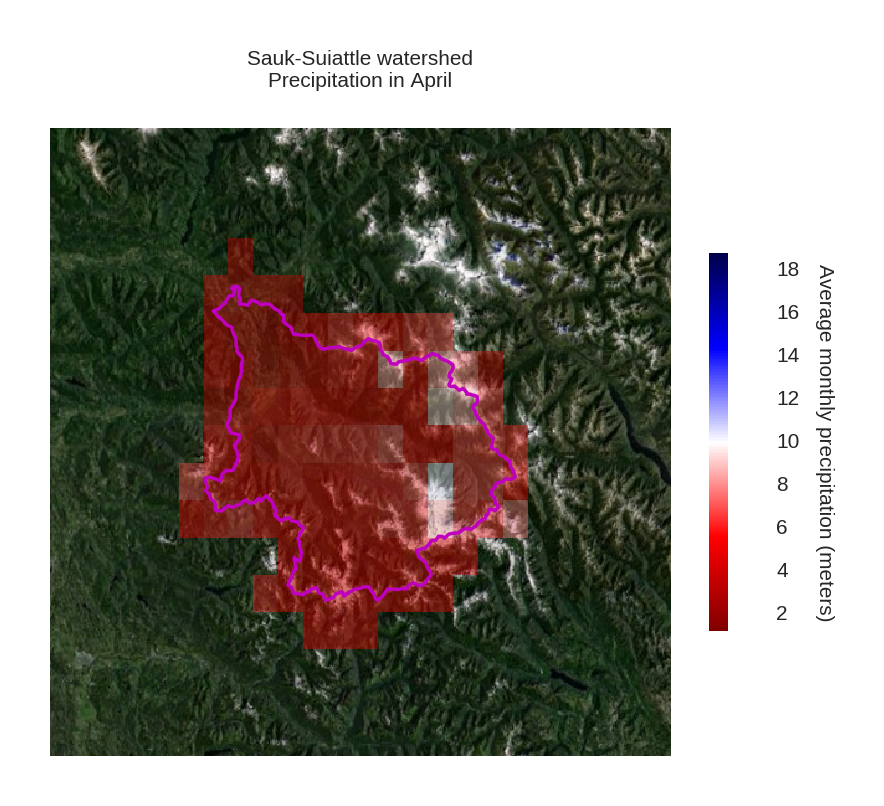

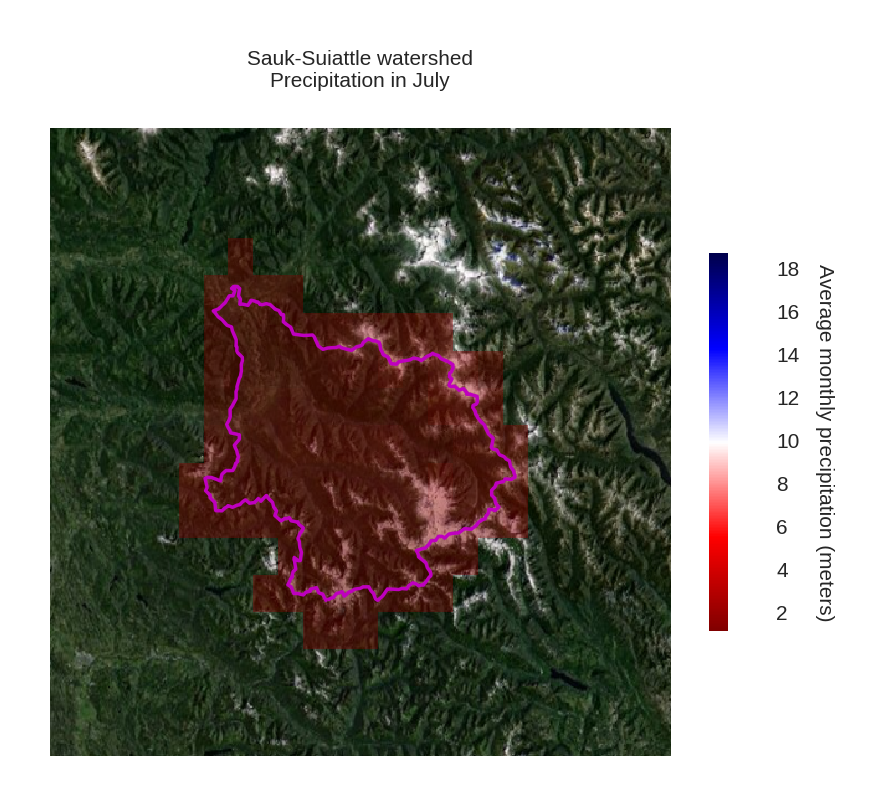

In [26]:
# loop through even months in the water year
for ind, eachmonth in enumerate([10, 1, 4, 7]):
    
    monthlabel = pd.datetime.strptime(str(eachmonth), '%m')
    ax1 = ogh.renderValuesInPoints(vardf=ltm['month_PRECIP_dailymet_livneh2013'], 
                                   vardf_dateindex=eachmonth,
                                   shapefile=sauk,
                                   outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                                   plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                                   colorbar_label='Average monthly precipitation (meters)',
                                   spatial_resolution=1/16, margin=0.5, epsg=3857,
                                   basemap_image='ESRI_Imagery_World_2D',
                                   cmap='seismic_r')

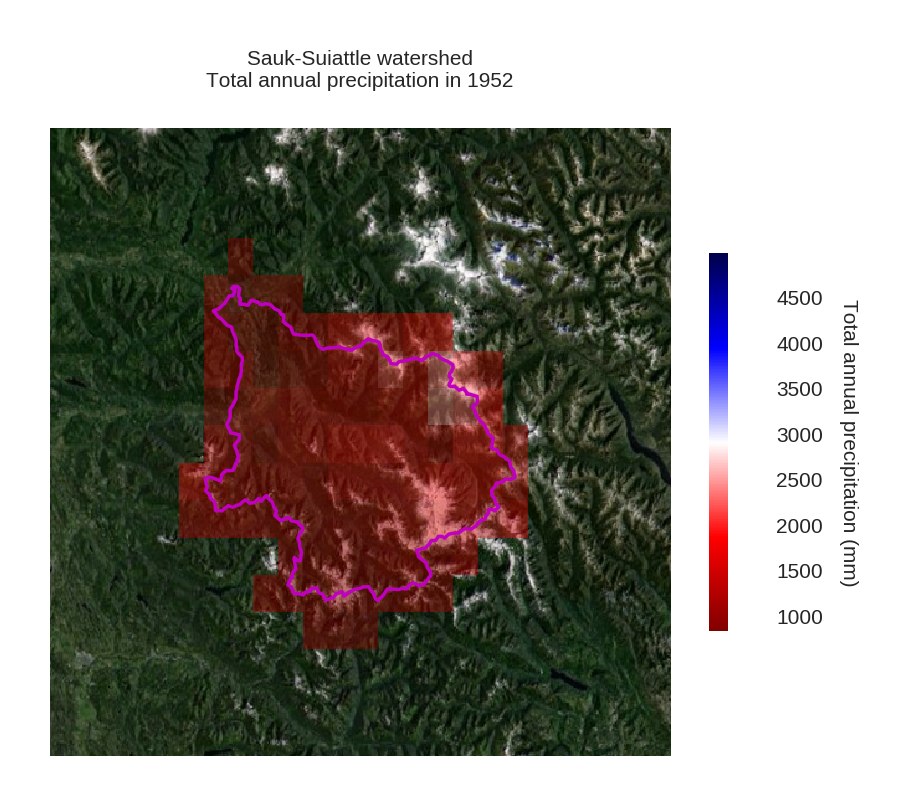

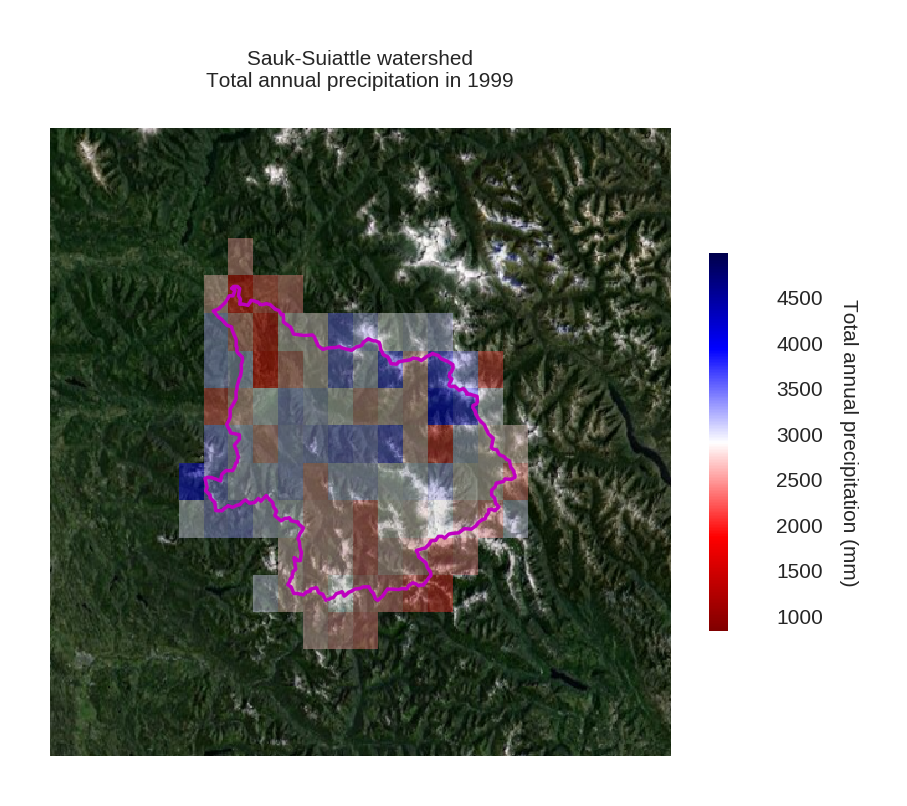

In [29]:
# visualize the annual precipitation within years of historic lows
ogh.renderValuesInPoints(vardf=ltm['yearsum_PRECIP_dailymet_livneh2013'], 
                         vardf_dateindex=1952,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(1952)),
                         plottitle='Sauk-Suiattle watershed'+'\nTotal annual precipitation in '+ str(1952),
                         colorbar_label='Total annual precipitation (mm)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='ESRI_Imagery_World_2D',
                         cmap='seismic_r')

# loop through even months in the water year
ogh.renderValuesInPoints(vardf=ltm['yearsum_PRECIP_dailymet_livneh2013'], 
                         vardf_dateindex=1999,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(1999)),
                         plottitle='Sauk-Suiattle watershed'+'\nTotal annual precipitation in '+ str(1999),
                         colorbar_label='Total annual precipitation (mm)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='ESRI_Imagery_World_2D',
                         cmap='seismic_r')

## Read in VIC endpoints from the dailyvic_livneh2013 datasets

## 4. Visualize monthly precipitation spatially using Livneh et al., 2013 Meteorology data

### Apply different plotting options:

time-index option <br />
Basemap option <br />
colormap option <br />
projection option <br />

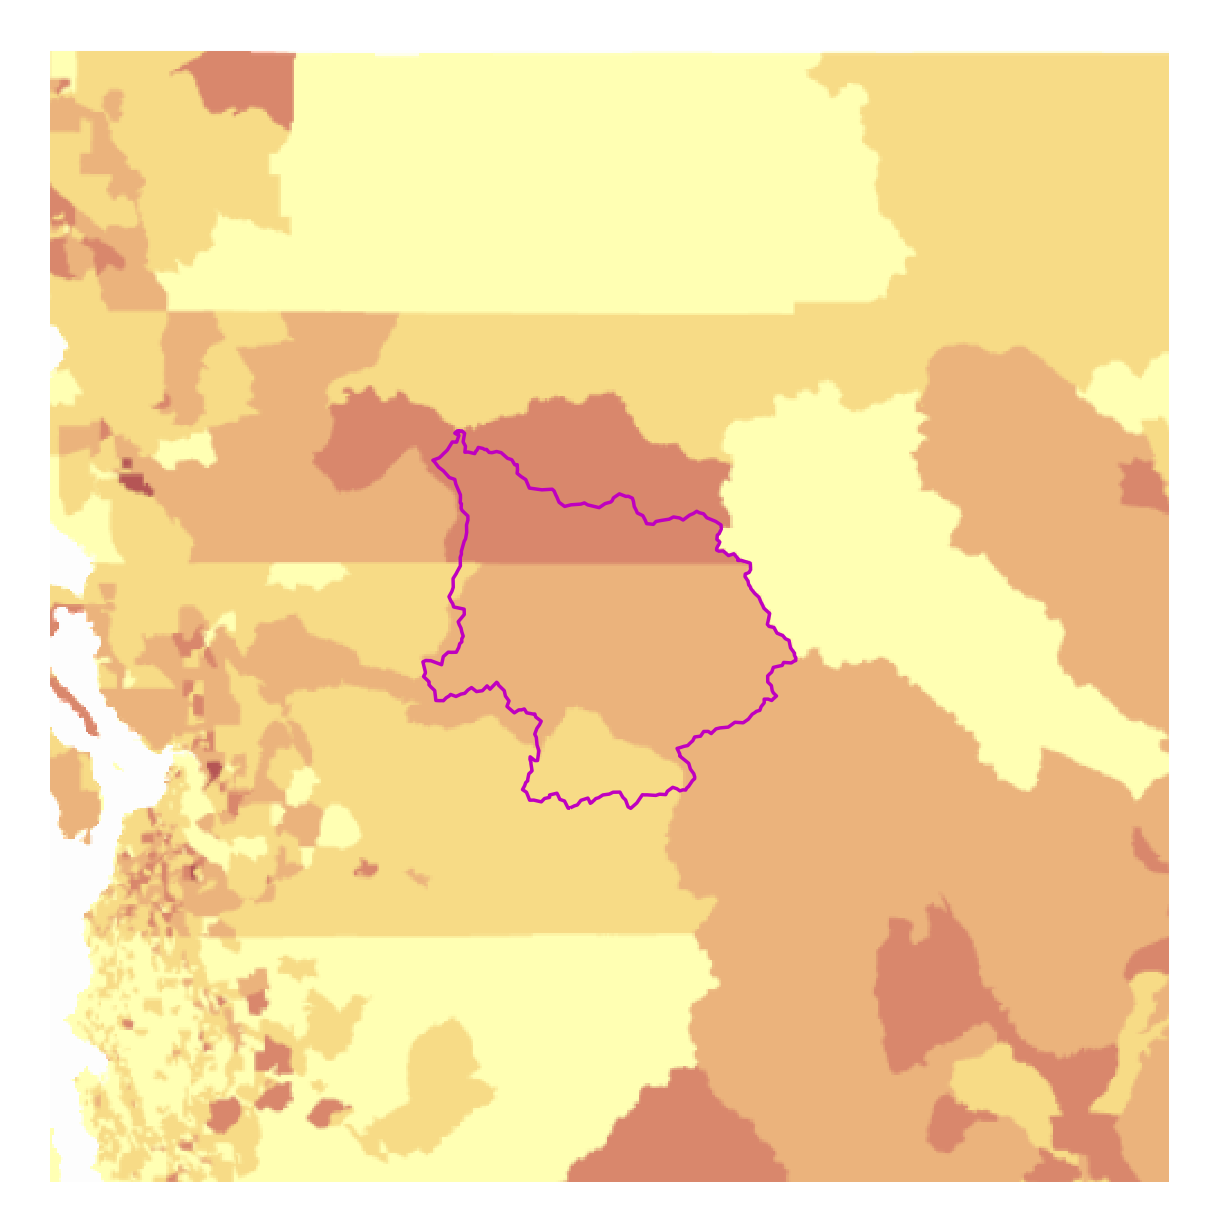

In [11]:
test = ogh.renderWatershed(shapefile=sauk, 
                           outfilepath=os.path.join(homedir, 'SaukPrecipSVI{0}.png'.format(monthlabel.strftime('%b'))), 
                           epsg=3857, margin=1,
                           basemap_image='Demographics/USA_Social_Vulnerability_Index')

In [ ]:
ogh.renderValuesInPoints(vardf=ltm['month_PRECIP_dailymet_livneh2013'],
                             vardf_dateindex=eachmonth,
                             shapefile=sauk, 
                             outfilepath=os.path.join(homedir, 'SaukPrecipSVI{0}.png'.format(monthlabel.strftime('%b'))),
                             plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                             colorbar_label='Average monthly precipitation (meters)',
                             spatial_resolution=1/16, 
                             margin=0, 
                             epsg=3857,
                             basemap_image='Demographics/USA_Social_Vulnerability_Index',
                             cmap='gray_r')

In [8]:
%%time
for eachmonth in [6,12]:
    monthlabel = pd.datetime.strptime(str(eachmonth), '%m')

    ogh.renderValuesInPoints(vardf=ltm['month_PRECIP_dailymet_livneh2013'],
                             vardf_dateindex=eachmonth,
                             shapefile=sauk, 
                             outfilepath=os.path.join(homedir, 'SaukPrecipSVI{0}.png'.format(monthlabel.strftime('%b'))),
                             plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                             colorbar_label='Average monthly precipitation (meters)',
                             spatial_resolution=1/16, 
                             margin=0, 
                             epsg=3857,
                             basemap_image='Demographics/USA_Social_Vulnerability_Index',
                             cmap='gray_r')

    ogh.renderValuesInPoints(vardf=ltm['month_PRECIP_dailymet_livneh2013'],
                             vardf_dateindex=eachmonth,
                             shapefile=sauk, 
                             outfilepath=os.path.join(homedir, 'SaukPrecipStMap{0}.png'.format(monthlabel.strftime('%b'))),
                             plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                             colorbar_label='Average monthly precipitation (meters)',
                             spatial_resolution=1/16,
                             margin=0.5, 
                             epsg=3857,
                             basemap_image='ESRI_StreetMap_World_2D',
                             cmap='gray_r')

    ogh.renderValuesInPoints(vardf=ltm['month_PRECIP_dailymet_livneh2013'],
                             vardf_dateindex=eachmonth,
                             shapefile=sauk, 
                             outfilepath=os.path.join(homedir, 'SaukPrecipESRIImagery{0}.png'.format(monthlabel.strftime('%b'))),
                             plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                             colorbar_label='Average monthly precipitation (meters)',
                             spatial_resolution=1/16, 
                             margin=0.5, 
                             epsg=3857,
                             basemap_image='ESRI_Imagery_World_2D',
                             cmap='gray_r')

    ogh.renderValuesInPoints(vardf=ltm['month_PRECIP_dailymet_livneh2013'],
                             vardf_dateindex=eachmonth,
                             shapefile=sauk, 
                             outfilepath=os.path.join(homedir, 'SaukPrecipWhiteHills{0}.png'.format(monthlabel.strftime('%b'))),
                             plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                             colorbar_label='Average monthly precipitation (meters)',
                             spatial_resolution=1/16, 
                             margin=0.5, 
                             epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='seismic_r')

NameError: name 'ltm' is not defined

### Visualize monthly precipitation difference between different gridded data products

## comparison to WRF data from Salathe et al., 2014

In [33]:
%%time
ltm = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailywrf_salathe2014',
                               colvar=None,
                               file_start_date=dr2['start_date'], 
                               file_end_date=dr2['end_date'],
                               file_time_step=dr2['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm)

Number of data files within elevation range (164.0:2216.0): 99
PRECIP dataframe reading to start: 0:00:00.148631
PRECIP dataframe complete:0:00:01.189326
TMAX dataframe reading to start: 0:00:01.339630
TMAX dataframe complete:0:00:02.294740
TMIN dataframe reading to start: 0:00:02.444435
TMIN dataframe complete:0:00:03.599650
WINDSPD dataframe reading to start: 0:00:03.749258
WINDSPD dataframe complete:0:00:04.703393
PRECIP_dailywrf_salathe2014 calculations completed in 0:00:00.092415
TMAX_dailywrf_salathe2014 calculations completed in 0:00:00.084616
TMIN_dailywrf_salathe2014 calculations completed in 0:00:00.085382
WINDSPD_dailywrf_salathe2014 calculations completed in 0:00:00.085316
CPU times: user 8.89 s, sys: 1.07 s, total: 9.96 s
Wall time: 5.07 s


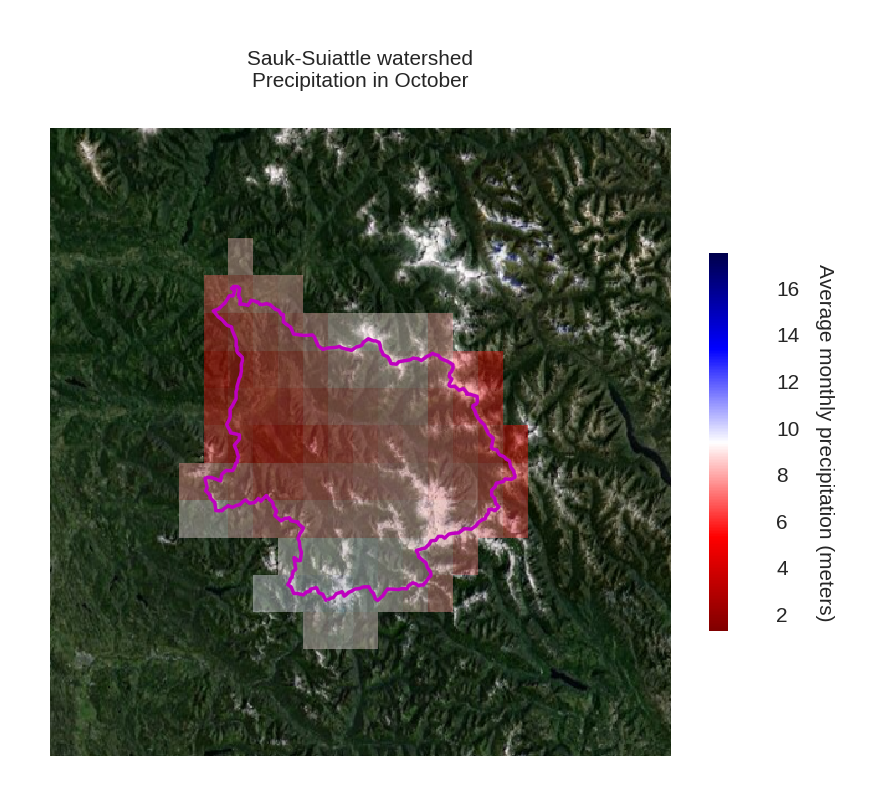

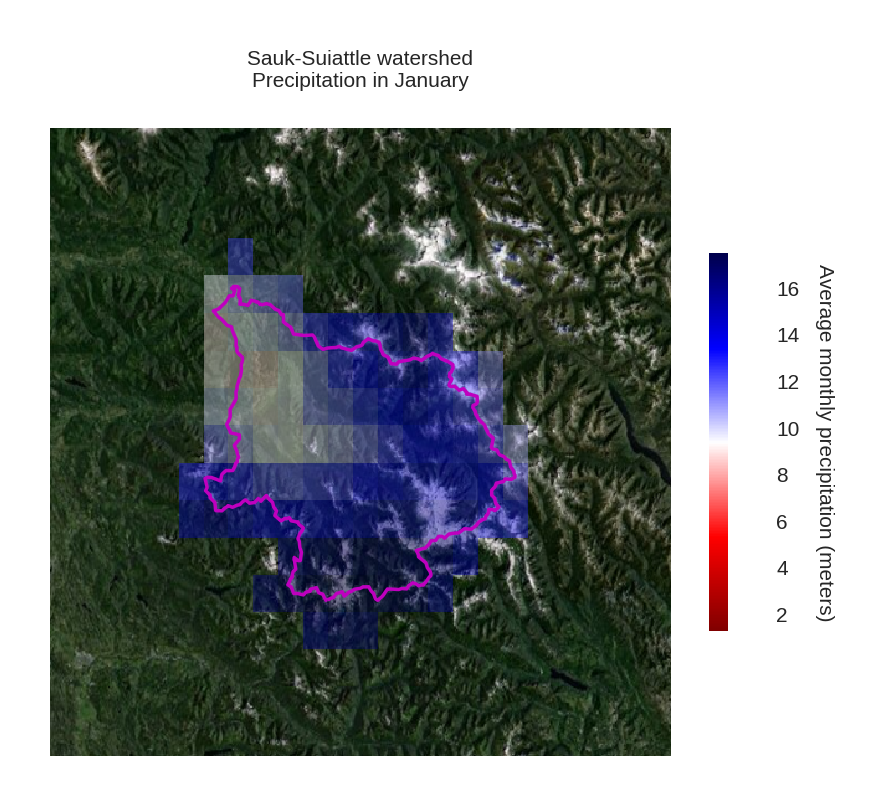

In [34]:
for month in [10, 1, 4, 7]:
    monthlabel = pd.datetime.strptime(str(month), '%m')
    outfile='SaukSalathePrecip{0}.png'.format(monthlabel.strftime('%b'))
    
    ax1 = ogh.renderValuesInPoints(vardf=ltm['month_PRECIP_dailywrf_salathe2014'],
                                   vardf_dateindex=month,
                                   shapefile=sauk, 
                                   basemap_image='ESRI_Imagery_World_2D',
                                   cmap='seismic_r',
                                   plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+monthlabel.strftime('%B'),
                                   colorbar_label='Average monthly precipitation (meters)',
                                   outfilepath=os.path.join(homedir, outfile))

In [ ]:
t3 = ltm['month_PRECIP_dailywrf_salathe2014'].copy()
t3

station = ogh.findStationCode(mappingfile=mappingfile1, colvalue=11, colvar='FID')
station[0]

elev = sorted(ogh.mappingfileToDF(mappingfile1, colvar=None)[0]['ELEV'].unique())
colors=pd.qcut(np.array(elev), 5, labels=['red','orange','yellow','green','blue'])

# 6. Compare gridded model to point observations

### Read in  SNOTEL data - assess available data 
If you want to plot observed snotel point precipitation or temperature with the gridded climate data, set to 'Y' 
Give name of Snotel file and name to be used in figure legends. 
File format: Daily SNOTEL Data Report - Historic - By individual SNOTEL site, standard sensors (https://www.wcc.nrcs.usda.gov/snow/snotel-data.html)

## 10. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

Create list of files to save to HydroShare. Verify location and names.

In [ ]:
ThisNotebook='Observatory_Sauk_TreatGeoSelf.ipynb' #check name for consistency
climate2013_tar = 'livneh2013.tar.gz'
climate2015_tar = 'livneh2015.tar.gz'
wrf_tar = 'salathe2014.tar.gz'
mappingfile = 'Sauk_mappingfile.csv'

files=[ThisNotebook, mappingfile, climate2013_tar, climate2015_tar, wrf_tar]

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Results from testing out the TreatGeoSelf utility'
abstract = 'This the output from the TreatGeoSelf utility integration notebook.'
keywords = ['Sauk', 'climate', 'Landlab','hydromet','watershed'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)